# Hydration spot

Hydration_spot performs the Designing water CV described in "Water regulates the residence time of Benzamidine in Trypsin ", N. Ansari, V. Rizzi and M. Parrinello, Nat. Communicat., 2022,13:5438. This script is written by N. Ansari and Dr. Umberto Raucci. 

If you use this script please cite the mentioned paper.

# Setup

In [2]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(threshold=np.inf)
import mdshare
import mdtraj as md
import os
import sys
from descartes import PolygonPatch
import matplotlib.pyplot as plt
import alphashape
import timeit
import trimesh 
import argparse
import datetime
from itertools import groupby
from mpl_toolkits.mplot3d import Axes3D
import nglview as nv
import ipywidgets
from sklearn.cluster import KMeans 
from platform import python_version
#python_version()


# Function 

In [3]:
def check_water(Nwat,alpha_shape,XYZ_wat,debug):

# Check whether water id inside or outside of the convex hull
    Win = []
    Wout = []
    index = [0] * Nwat
    for i in range(Nwat):
        wat = XYZ_wat[i] # analysis point
#        if alpha_shape.contains([wat]) == True:
        if alpha_shape.contains([wat]):
             Win.append(wat)
             index[i] = 1
        else:
             Wout.append(wat)

    if debug:
        N_Win = len(Win)
        N_Wout = len(Wout)
        print ('Water inside:', N_Win)
        print ('Water outside:', N_Wout)
        plot_alpha_shape_with_point(alpha_shape, Win, Wout)

    return index 

def plot_alpha_shape_with_point(alpha_shape,Win,Wout):

# plotting alpha_shape with waters 
    N_Win = len(Win)
    N_Wout = len(Wout)

    x_in = [Win[i][0] for i in range(N_Win)]
    y_in = [Win[i][1] for i in range(N_Win)]
    z_in = [Win[i][2] for i in range(N_Win)]

    x_out = [Wout[i][0] for i in range(N_Wout)]
    y_out = [Wout[i][1] for i in range(N_Wout)]
    z_out = [Wout[i][2] for i in range(N_Wout)]

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_trisurf(*zip(*alpha_shape.vertices), triangles=alpha_shape.faces, alpha=0.4)
    ax.scatter(x_in,y_in,z_in, color='red')
    ax.scatter(x_out,y_out,z_out, color='blue', alpha=0.03)
    plt.show()
    
def plot_alpha_shape(alpha_shape):

# plotting alpha_shape of the first frame
    ax.scatter(x_out,y_out,z_out, color='blue', alpha=0.03)
    plt.show()

def lifetime(Nwat,min_time,time_step,water,W_index,traj):
# Life time analysis 

    begin_time = datetime.datetime.now()
    print ('------- Water Life Time Analysis ---')

    life_time = []
    Active_water = []
    Active_water_XYZ = []
    min_count = round(min_time/time_step)
    for j in range(Nwat):
            atom_idx = water[j] #  is the index of protein  input parameter 
            check_lifetime = monotoneRanges(extract(W_index,j), min_count)
            life_time.append(check_lifetime) 
            if check_lifetime: 
                for frame in range(len(check_lifetime)):
                    Sframe_idx = check_lifetime[frame][0]
                    Eframe_idx = check_lifetime[frame][1]
                    for P in range(Sframe_idx,Eframe_idx+1):
                        Active_water_XYZ.append((tuple(traj.xyz[P, atom_idx,:])))

    XYZ_W_active = (np.array(Active_water_XYZ))*10. 

    with open('Active_water.xyz', 'w') as f:
        f.write("%d\n" % len(XYZ_W_active))
        f.write("\n" )
        for item in range(len(XYZ_W_active)):
                f.write("x %.4f\t %.4f\t %.4f \n" % (XYZ_W_active[item,0],XYZ_W_active[item,1],XYZ_W_active[item,2]))
        f.close()

    print('Time',datetime.datetime.now()-begin_time) 
    return XYZ_W_active


def read_active_water(filename):
    """Read XYZ file and return atom names and coordinates

    Args:
        filename:  Name of xyz data file

    Returns:
        coords: Cartesian coordinates for every frame.
    """
    print ('------- Reading Active_water.xyz ---')
    coors = []
    with open(filename, 'r') as f:
        for line in f:
            try:
                natm = int(line)  # Read number of atoms
                next(f)     # Skip over comments
                for i in range(natm):
                    line = next(f).split()
                    coors.append(
                        [float(line[1]), float(line[2]), float(line[3])])
            except (TypeError, IOError, IndexError, StopIteration):
                raise ValueError('Incorrect XYZ file format')
    coors = np.array(coors)
    return coors


def extract(lst,nelem):
# extract nth  element of each sublist in a list of lists

    return [item[nelem] for item in lst]


def monotoneRanges(water_residence, min_count):

    g = groupby(enumerate(water_residence), lambda x:x[1])
    l = [(x[0], list(x[1])) for x in g if x[0] == 1]    # check if elements are equal 1 
    output = [(x[0], len(x[1]), x[1][0][0]) for x in l]

    idx = [[output[i][2],output[i][2]+(output[i][1]-1)] for i in range(len(output)) if output[i][1] >= min_count]
    return idx

def clustering(Ncluster,XYZ_W_active, cluster):

    begin_time = datetime.datetime.now()
    print ('------- KMeans clustering  ---------')
# Clustering

    kmeans = KMeans(n_clusters=Ncluster, random_state=0).fit(XYZ_W_active)
    center= kmeans.cluster_centers_

    with open('Water_centroid.xyz', 'w') as f:
        f.write("%d\n" % len(center))
        f.write("\n" )
        for itemm in range(len(center)):
                f.write("C %.4f\t %.4f\t %.4f \n" % (center[itemm,0],center[itemm,1],center[itemm,2]))
    f.close()

    print('Time',datetime.datetime.now()-begin_time)
    print(datetime.datetime.now())
    return



## Trajectory path

### INPUT

In [5]:
input_trajectory='/Users/narjesansari/Downloads/narjes_traj/short.xtc'   # path of input trajectory 
input_topol='/Users/narjesansari/Downloads/narjes_traj/0o_topo.pdb'      # path of topology file

Total Step: 100


# Loading Trajectory


In [27]:
trajectory=input_trajectory
topol=input_topol

traj = md.load(trajectory, top=topol)
Nstep = len(traj)

print ('Total Step:', Nstep)

print ('------- Loading Trajectory ---------')
traj = md.load(trajectory, top=topol)
Nstep = len(traj)
print ('Total Step:', Nstep)
print ('Time step =',traj.timestep, 'ps')

table, bonds = traj.topology.to_dataframe()
#print(table.head())
topology = traj.topology

Total Step: 100
------- Loading Trajectory ---------
Total Step: 100
Time step = 10.0 ps


# Vertex of alpha-shape

### INPUT

Define the index of alpha-Carbon to build the alpha-shape.

In [13]:
C_alpha=topology.select('name CA and resid 389 390 391 26 209 211 212 213 21 22 25 105 108 109 98 99 100 101 102 103 104 334 214 215 394 395 397 398 18 19 20 23 216 217 17 95 219 332 333 335 336 337 338 91 93 94 96 97 400 401 218 220 13 221 222 223 224 225 226 339 340 341 8 9 12 150 151 154 143 144 147 374 68 69 227 228 229 230 343 2 3 4 5 148 146 367 368 369')

Define the O atoms of water 

In [11]:
water=topology.select("water and name O")

In [12]:
Nwat = len(water)
print ('Total water:', Nwat)

Total water: 22084


### Building Alpha Shape

### INPUT

In [29]:
alpha=1.3

In [30]:
print ('------- Building Alpha Shape -------')

alpha_input = alpha
Nstep = len(traj) 
Nwat = len(water) 
W_index = []


for i in range(Nstep):
    XYZ_wat=traj.xyz[i, water,:]   # water coordinates
    XYZ_CA=traj.xyz[i, C_alpha,:]  # Calpha coordinates 
       
    print ('----- Builgind Alpha shape step:',i)
    alpha_shape = alphashape.alphashape(XYZ_CA, lambda ind, r: 1.0 + any( np.array(XYZ_CA)[ind][:,0] == 0.0))#alpha)
    watertight = alpha_shape.is_watertight
    if watertight:
        print('Mesh is watertight:',watertight)
    else:
        print('WARNING: Mesh is not watertight, decreasing alpha value')
    while not watertight:
        alpha = alpha-0.01
        alpha_shape = alphashape.alphashape(XYZ_CA, alpha)
        watertight = alpha_shape.is_watertight
        print('Mesh is watertight:',watertight,'alpha=',alpha)
    alpha= alpha_input 
    W_index.append(check_water(Nwat,alpha_shape,XYZ_wat,False)) 



------- Building Alpha Shape -------
----- Builgind Alpha shape step: 0
Mesh is watertight: True
----- Builgind Alpha shape step: 1
Mesh is watertight: True
----- Builgind Alpha shape step: 2
Mesh is watertight: True
----- Builgind Alpha shape step: 3
Mesh is watertight: True
----- Builgind Alpha shape step: 4
Mesh is watertight: True
----- Builgind Alpha shape step: 5
Mesh is watertight: True
----- Builgind Alpha shape step: 6
Mesh is watertight: True
----- Builgind Alpha shape step: 7
Mesh is watertight: True
----- Builgind Alpha shape step: 8
Mesh is watertight: True
----- Builgind Alpha shape step: 9
Mesh is watertight: True
----- Builgind Alpha shape step: 10
Mesh is watertight: True
----- Builgind Alpha shape step: 11
Mesh is watertight: True
----- Builgind Alpha shape step: 12
Mesh is watertight: True
----- Builgind Alpha shape step: 13
Mesh is watertight: False alpha= 1.29
Mesh is watertight: False alpha= 1.28
Mesh is watertight: False alpha= 1.27
Mesh is watertight: False alph

Number of water molecules inside the concex hull for each frame

In [19]:
WATERNUM=np.array(W_index)
num_water=np. sum(WATERNUM,axis=1)
print(num_water)

[75 69 65 61 66 64 67 66 62 64 70 66 65 64 68 65 62 62 64 65 68 68 64 64
 64 69 70 73 66 70 72 74 69 75 70 75 80 76 76 70 71 74 68 68 71 72 67 65
 70 65 65 69 71 74 69 64 74 69 72 67 71 68 63 63 66 65 66 64 65 64 60 64
 60 68 68 61 62 65 64 61 62 61 64 69 67 64 62 56 58 64 66 69 66 67 62 62
 63 68 62 71]


## Lifetime

### Input

In [20]:
min_time= 1000              ### life time threshold  (200 ps)
time_step=traj.timestep  ### the time step of simulation ps
print('Time step=',time_step, 'ps')
print('Life time tershhold=',min_time, 'ps')

Time step= 10.0 ps
Life time tershhold= 1000 ps


In [21]:
Nwat = len(water)    
life_time = []
Active_water = []
Active_water_XYZ = []
min_time= 1000              ### life time threshold  (200 ps)
time_step=traj.timestep  ### the time step of simulation ps
print('Time step=',time_step, 'ps')
print('Life time tershhold=',min_time, 'ps')
min_count = min_time/time_step

for j in range(Nwat):
            atom_idx = water[j] #  is the index of protein  input parameter 
            #print(atom_idx)
            check_lifetime = monotoneRanges(extract(W_index,j), min_count)
            life_time.append(check_lifetime) 
            #print(life_time)
            if check_lifetime: 
               for frame in range(len(check_lifetime)):
                   Sframe_idx = check_lifetime[frame][0]
                   Eframe_idx = check_lifetime[frame][1]
                   for P in range(Sframe_idx,Eframe_idx+1):
                        Active_water_XYZ.append((tuple(traj.xyz[P, atom_idx,:])))


XYZ_W_active = (np.array(Active_water_XYZ))*10. 

### life time of water molecules
XYZ_W_active=lifetime(Nwat,min_time,time_step,water,W_index,traj)

### XYZ coordinate of water molecules in Angstrom

x_in = [XYZ_W_active[i][0] for i in range(len(XYZ_W_active))]
y_in = [XYZ_W_active[i][1] for i in range(len(XYZ_W_active))]
z_in = [XYZ_W_active[i][2] for i in range(len(XYZ_W_active))]


Time step= 10.0 ps
Life time tershhold= 1000 ps
------- Water Life Time Analysis ---
Time 0:00:00.230484


Plot distribution of the long-lived water molecules inside the surface

<IPython.core.display.Javascript object>


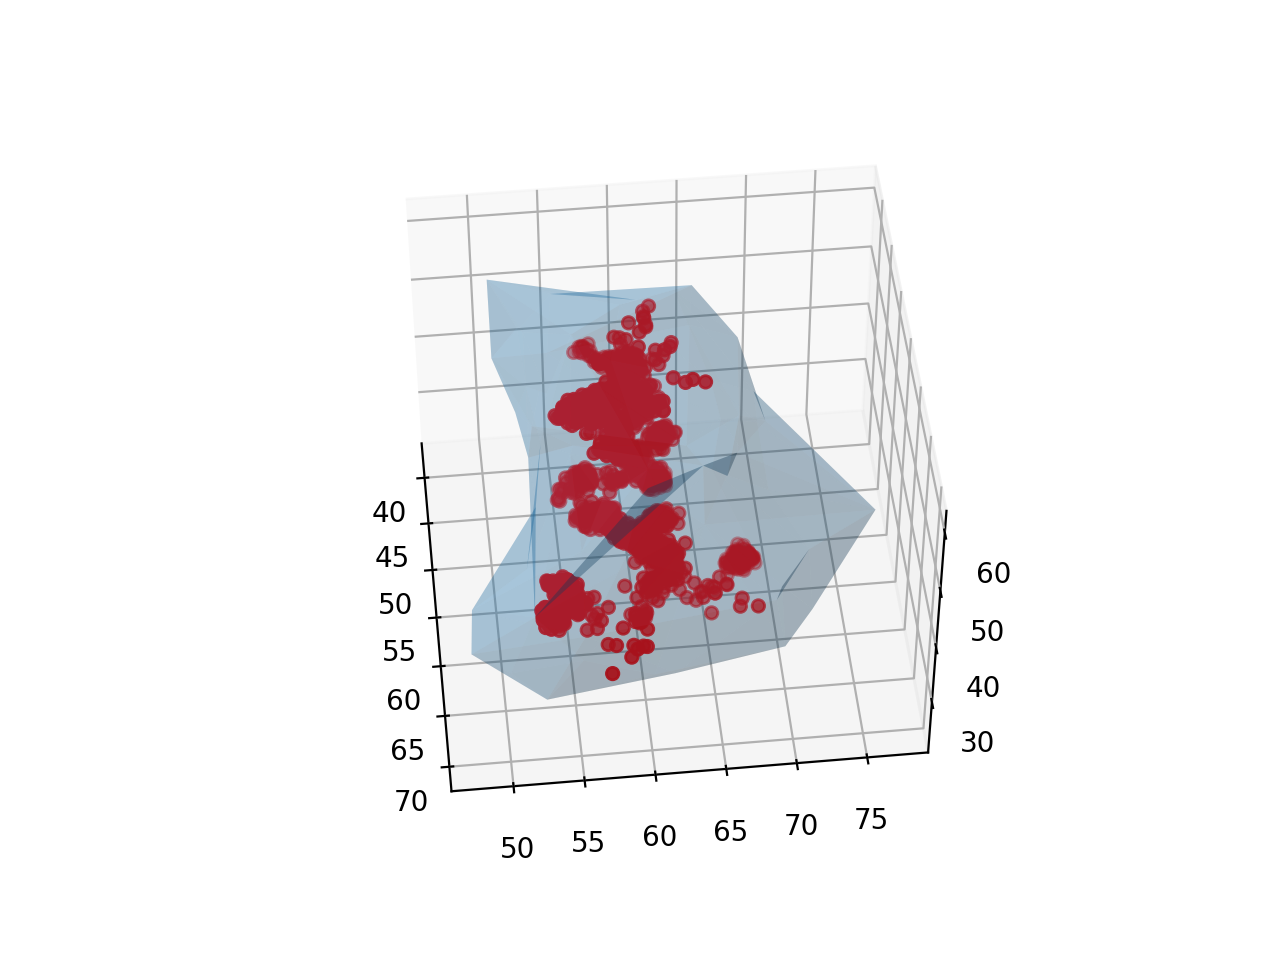

In [23]:
 fig = plt.figure()
 ax = plt.axes(projection='3d')
 ax.scatter(x_in,y_in,z_in, color='red')
 ax.plot_trisurf(*zip(*alpha_shape.vertices*10), triangles=alpha_shape.faces, alpha=0.2)
 plt.show()

## Clustering

### INPUT

In [24]:
Ncluster=10

In [25]:
kmeans = KMeans(n_clusters=Ncluster, random_state=0).fit(XYZ_W_active)
center= kmeans.cluster_centers_


Plot distribution of the long-lived water molecules inside the surface + center of clusters

<IPython.core.display.Javascript object>


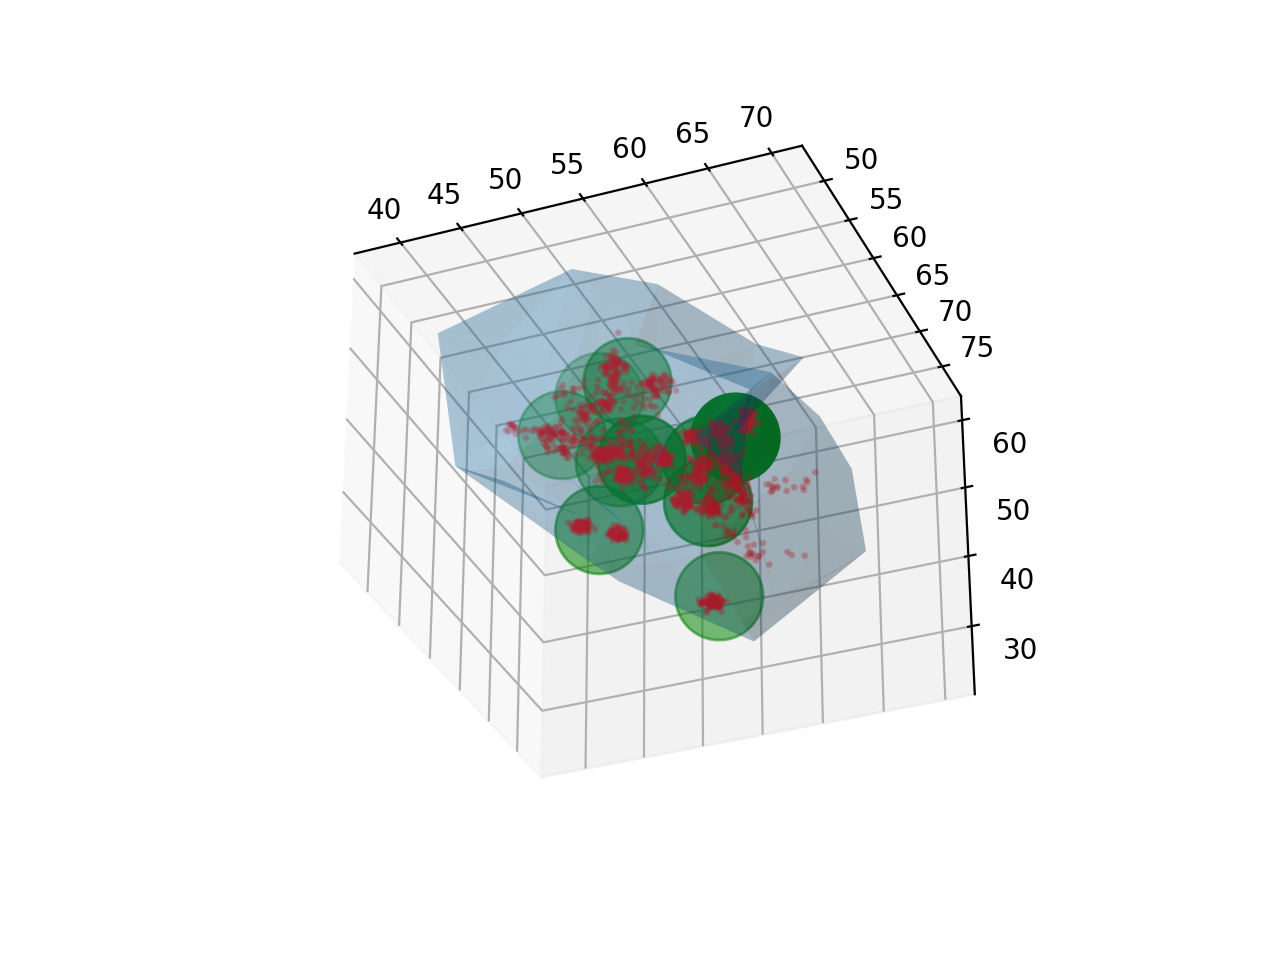

In [26]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(x_in,y_in,z_in, color='red',alpha=0.2,s=10,marker='.')
ax.scatter(center[:,0],center[:,1],center[:,2], color='green',s=1000,marker='o')
ax.plot_trisurf(*zip(*alpha_shape.vertices*10), triangles=alpha_shape.faces, alpha=0.2)
plt.show()

Save the coordinate of cluster centers and long-lived water molecules

In [ ]:
with open('/Users/narjesansari/Downloads/narjes_traj/Water_centroid.xyz', 'w') as f:
    f.write("%d\n" % len(center))
    f.write("\n" )
    for itemm in range(len(center)):
            f.write("C %.4f\t %.4f\t %.4f \n" % (center[itemm,0],center[itemm,1],center[itemm,2]))
f.close()


with open('/Users/narjesansari/Downloads/narjes_traj/Active_water.xyz', 'w') as f:
    f.write("%d\n" % len(XYZ_W_active))
    f.write("\n" )
    for item in range(len(XYZ_W_active)):
            f.write("x %.4f\t %.4f\t %.4f \n" % (XYZ_W_active[item,0],XYZ_W_active[item,1],XYZ_W_active[item,2]))
    f.close()